# CS 330 Autumn 2019/2020 Homework 1
# Data Processing and Memory Augmented Neural Networks

---

# Overview

In this assignment we will be looking at meta-learing for few shot classification.

You will

1. Learn how to process and partition data for meta learning problems, where training is done over a **distribution of training tasks** $p(\mathcal T)$.

2. Implement and train **memory augmented neural networks**, which meta-learn through a recurrent network.

3. Analyze the learning performance for **different size problems**.

4. Experiment with **model parameters** and explore how they improve performance.

We will be working with the **Omniglot dataset** [[1]](#References)
, a dataset for one-shot learning which contains:

* 1623 different characters

* from 50 different languages.

* For each character there are 20 28x28 images.

We are interested in training models for K-shot, N-way classification, that is, we want to train a classifier to distinguish between **N previously unseen characters**, given only **K labeled examples of each character**.

### Submission:

To submit your homework, submit one pdf report and one zip file to Grade-Scope, where the report will contain answers to the deliverables listed below and the zip filecontains your code (*hw1.py*, *load_data.py*) with the filled in solutions.

### Code Overview: The code consists of two files

* load_data.py: Contains code to load batches of images and labels

* hw1.py: Contains the network architecture/loss functions and training script.

There is also the omniglot resized folder which contains the data. *You should not modify this folder.*

### Dependencies:

We expect code in Python 3.5+ with Pillow, scipy, numpy, tensorflow installed.

# Problem 1: Data Processing for Few-Shot Classification

Before training any models, you must write code to sample batches for training. Fill in the sample batch function in the **DataGenerator class** in the *load_data.py* file.

The class already has variables defined for

* batch size batch_size ( $B$ ),

* number of classes num_classes ( $N$ ),

* and number of samples per class num_samples_per_class ( $K$ ).

Your code should:

1. Sample $N$ **different classes** from either the specified *train, test, or validation* folders.


2. Load $K$ **images per class** and collect the associated labels.


3. Format the data and return two numpy matrices:
   
   * one of **flattened images** with shape $[ B, K, N, 784 ]$,
   
   * and one of **one-hot labels** $[ B, K, N, N ]$
   

---

**Note:** This notebook is self contained, so all auxiliary functions are defined here.

In [1]:
import os
import imageio
import numpy as np

In [2]:
def get_images(paths, labels, nb_samples=None, shuffle=True):
    """
    Takes a set of character folders and labels and returns paths to image files
    paired with labels.
    Args:
        paths:  A list of character folders
        labels: List or numpy array of same length as paths
        nb_samples: Number of images to retrieve per character
    Returns:
        List of (label, image_path) tuples
    """
    if nb_samples is not None:
        sampler = lambda x: np.random.choice(x, nb_samples)
    else:
        sampler = lambda x: x
    images_labels = [(i, os.path.join(path, image))
                     for i, path in zip(labels, paths)
                     for image in sampler(os.listdir(path))]
    if shuffle:
        np.random.shuffle(images_labels)
    return images_labels


def image_file_to_array(filename, dim_input):
    """
    Takes an image path and returns numpy array
    Args:
        filename: Image filename
        dim_input: Flattened shape of image
    Returns:
        1 channel image
    """
    image = imageio.imread(filename)
    image = image.reshape([dim_input])
    image = image.astype(np.float32) / 255.0
    image = 1.0 - image
    return image

In [3]:
class DataGenerator(object):
    """
    Data Generator capable of generating batches of Omniglot data.
    A "class" is considered a class of omniglot digits.
    """

    def __init__(self, num_classes, num_samples_per_class, config={}):
        """
        Args:
            num_classes: Number of classes for classification (K-way)
            num_samples_per_class: num samples to generate per class in one batch
            batch_size: size of meta batch size (e.g. number of functions)
        """
        self.num_classes = num_classes
        self.num_samples_per_class = num_samples_per_class
        

        config = {'sad':''}

        data_folder = config.get('data_folder', './omniglot_resized')
        self.img_size = config.get('img_size', (28, 28))

        self.dim_input = np.prod(self.img_size)
        self.dim_output = self.num_classes

        character_folders = [os.path.join(data_folder, family, character)
                             for family in os.listdir(data_folder)
                             if os.path.isdir(os.path.join(data_folder, family))
                             for character in os.listdir(os.path.join(data_folder, family))
                             if os.path.isdir(os.path.join(data_folder, family, character))]

        np.random.seed(42)
        np.random.shuffle(character_folders)
        num_val = 100
        num_train = 1100
        self.metatrain_character_folders = character_folders[: num_train]
        self.metaval_character_folders = character_folders[
            num_train:num_train + num_val]
        self.metatest_character_folders = character_folders[
            num_train + num_val:]
        print("Data generator initialized. Shape: [B, {}, {}, 784]".format(self.num_samples_per_class, self.num_classes))

    def sample_batch(self, batch_type, batch_size=1):
        """
        Samples a batch for training, validation, or testing
        Args:
            batch_type: train/val/test
        Returns:
            A a tuple of (1) Image batch and (2) Label batch where
            image batch has shape [B, K, N, 784] and label batch has shape [B, K, N, N]
            where B is batch size, K is number of samples per class, N is number of classes
        """
        n_classes  = self.num_classes
        k_samples  = self.num_samples_per_class
        
        if batch_type == "train":
            folders = self.metatrain_character_folders
        elif batch_type == "val":
            folders = self.metaval_character_folders
        else:
            folders = self.metatest_character_folders

        #############################
        #### YOUR CODE GOES HERE ####
        pixels = 28*28
        all_image_batches = np.ndarray((batch_size, k_samples, n_classes, pixels))
        all_label_batches = np.ndarray((batch_size, k_samples, n_classes, n_classes))

        for b in range(batch_size):
            # Take N samples from all alphabet folders
            sample_paths  = np.random.choice(folders, n_classes)
            sample_labels = [os.path.basename(os.path.split(family)[0]) for family in sample_paths]
            images_labels = get_images(sample_paths, sample_labels, k_samples)
            
            count = 0
            for k in range(k_samples):
                for n in range(n_classes):
                    all_image_batches[b, k, n, :] = image_file_to_array(filename=images_labels[count][1], dim_input=pixels)
                    # Labels as one-hot vectors
                    all_label_batches[b, k, n, :] = np.zeros(n_classes)
                    all_label_batches[b, k, n, n] = 1
                    count += 1
            #############################
        return all_image_batches, all_label_batches

In [4]:
c = {'data_folder':'./'}

num_classes=5
num_samples_per_class=3

data = DataGenerator(num_classes, num_samples_per_class)

Data generator initialized. Shape: [B, 3, 5, 784]


In [5]:
images, labels = data.sample_batch('train', batch_size=10)
print("Batch of images of shape:", images.shape)
print("Batch of labels of shape:", labels.shape)

Batch of images of shape: (10, 3, 5, 784)
Batch of labels of shape: (10, 3, 5, 5)


Labels are relative to the classes in **each sample**.

We don't care about the actual language of each character, we only want to compare if they are the same class, or not.

In [6]:
for i in range(num_classes):
    print(labels[0,0,i])

[1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1.]


Let's explore the images:

In [7]:
import matplotlib.pyplot as plt

First meta-batch:


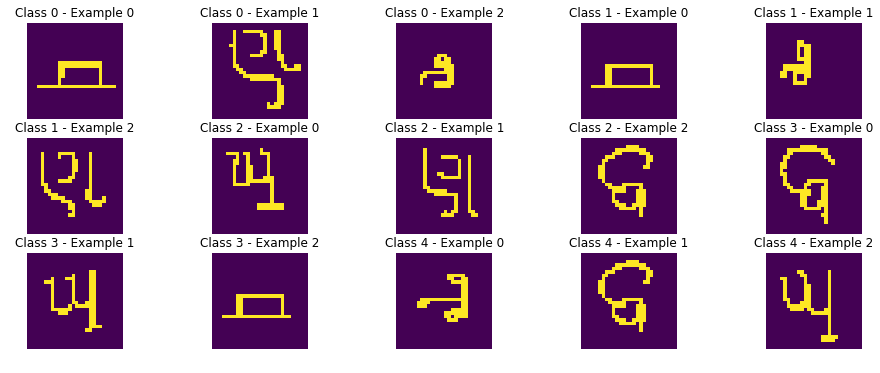

In [8]:
print("First meta-batch:")

plt.figure(figsize=(16, 6))
count = 0
for cl in range(num_classes):
    for sa in range(num_samples_per_class):
        plt.subplot(num_samples_per_class, num_classes, count + 1)
        plt.title("Class {} - Example {}".format(cl, sa))
        image = images[0, sa, cl].reshape((28,28))
        plt.imshow(image)
        plt.axis('off');
        count += 1

Second meta-batch:


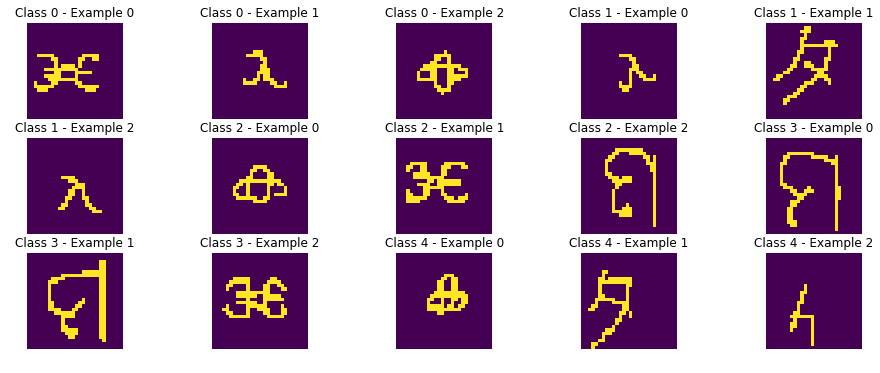

In [9]:
print("Second meta-batch:")

plt.figure(figsize=(16, 6))
count = 0
for cl in range(num_classes):
    for sa in range(num_samples_per_class):
        plt.subplot(num_samples_per_class, num_classes, count + 1)
        plt.title("Class {} - Example {}".format(cl, sa))
        image = images[1, sa, cl].reshape((28,28))
        plt.imshow(image)
        plt.axis('off');
        count += 1

About the data generator:

In [10]:
print("# of samples per class:", data.num_samples_per_class)
print("# of classes:",  data.num_classes)
print("Image size:",   data.img_size)
print("Input dimension:",  data.dim_input)
print("Output dimension:", data.dim_output)

# of samples per class: 3
# of classes: 5
Image size: (28, 28)
Input dimension: 784
Output dimension: 5


Distribution of our data folders:

In [11]:
print("# of meta train folders:", len(data.metatrain_character_folders))
print("# of meta val folders:  ", len(data.metaval_character_folders))
print("# of meta test folders: ", len(data.metatest_character_folders))

# of meta train folders: 1100
# of meta val folders:   100
# of meta test folders:  423


We can also access those folders directly:

In [12]:
data.metatrain_character_folders[0:5]

['./omniglot_resized/Japanese_(hiragana)/character06',
 './omniglot_resized/Tifinagh/character18',
 './omniglot_resized/Oriya/character14',
 './omniglot_resized/Sanskrit/character34',
 './omniglot_resized/Gurmukhi/character20']

In [13]:
data.metatest_character_folders[0:5]

['./omniglot_resized/Burmese_(Myanmar)/character25',
 './omniglot_resized/Gurmukhi/character29',
 './omniglot_resized/Anglo-Saxon_Futhorc/character02',
 './omniglot_resized/Malay_(Jawi_-_Arabic)/character11',
 './omniglot_resized/Kannada/character08']

### Helper functions.

In [14]:
get_images(data.metatest_character_folders[0:3],['1','N_Ko','Glagolitic'],1)

[('1', './omniglot_resized/Burmese_(Myanmar)/character25/0794_20.png'),
 ('Glagolitic',
  './omniglot_resized/Anglo-Saxon_Futhorc/character02/0297_09.png'),
 ('N_Ko', './omniglot_resized/Gurmukhi/character29/1188_05.png')]

Display "real" labels:

In [15]:
[os.path.basename(os.path.split(family)[0]) for family in data.metatest_character_folders[0:3]]

['Burmese_(Myanmar)', 'Gurmukhi', 'Anglo-Saxon_Futhorc']

Or plot a character directly from file

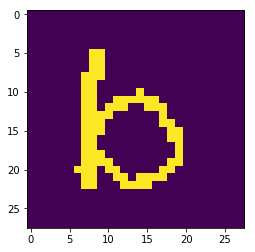

In [16]:
plt.imshow(image_file_to_array('./omniglot_resized/N_Ko/character12/0815_17.png', 784).reshape((28,28)))

# Problem 2: Memory Augmented Neural Networks [[2]](#References) [[3]](#References)

We will be attempting few shot classification using memory augmented neural networks.

The idea of memory augmented networks is to use a classifier with recurrent memory, such that information from the K examples of unseen classes informs classification through the hidden state of the network.

The data processing will be done as in SNAIL [[3]](#References).

Specifically, during training, you sample batches of $N$ **classes**, with $K + 1$ **samples per batch**.

Each set of labels and images are **concatenated together**, and then **all K** of these concatenated pairs are sequentially passed through the network.

Then the final example of each class is fed through the network (**concatenated with 0** instead of the true label). 

![figure-1.png](./img/figure-1.png)

The loss is computed between these final outputs and the ground truth label, which is then backpropagated through the network.

**Note:** The loss is **only** computed on the **last** set of $N$ classes.

The idea is that the network will learn how to encode the first $K$ examples of each class into memory such that it can be used to enable accurate classification on the $K + 1th$ example. See Figure 1.

In the *hw1.py* file: 

1. Fill in the *call* function of the *MANN* class to take in image tensor of shape $[B, K + 1, N, 784]$ and a label tensor of shape $[B, K + 1, N, N ]$ and output labels of shape $[B, K + 1, N, N ]$.

   The layers to use have already been defined for you in the init function.

   **Hint:** Remember to pass zeros, not the ground truth labels for the final $N$ examples.

2. Fill in the function called *loss_function* which takes as input the $[B, K + 1, N, N ]$ labels and $[B, K + 1, N, N ]$ and computes the **cross entropy loss**.

**Note:** Both of the above functions will need to backpropogated through, so **they need to bewritten in differentiable tensorflow**.

---

In [17]:
import tensorflow as tf
import datetime

In [18]:
# Check if tf version is 1.15
tf.__version__

'1.15.0'

In [25]:
def loss_function(preds, labels):
    """l
    Computes MANN loss
    Args:
        preds: [B, K+1, N, N] network output
        labels: [B, K+1, N, N] labels
    Returns:
        scalar loss
    """
    #############################
    #### YOUR CODE GOES HERE ####
    loss = tf.keras.losses.categorical_crossentropy(y_true=labels[:,-1:,:,:],
                                                    y_pred=preds[:, -1:,:,:],
                                                    from_logits=True)
    loss = tf.reduce_sum(loss)
    #############################
    return loss

class MANN(tf.keras.Model):

    def __init__(self, num_classes, samples_per_class):
        super(MANN, self).__init__()
        self.num_classes = num_classes
        self.samples_per_class = samples_per_class
        self.layer1 = tf.keras.layers.LSTM(128, return_sequences=True)
        self.layer2 = tf.keras.layers.LSTM(num_classes, return_sequences=True)

    def call(self, input_images, input_labels):
        """
        MANN
        Args:
            input_images: [B, K+1, N, 784] flattened images
            labels:       [B, K+1, N, N] ground truth labels
        Returns:
            [B, K+1, N, N] predictions
        """
        #############################
        #### YOUR CODE GOES HERE ####
        # Data processing as in SNAIL
        _, K, N, I = input_images.shape
        # First K data+labels (for each N classes)
        data1 = tf.concat([input_images[:,0:-1,:,:],
                           input_labels[:,0:-1,:,:]], axis=3)
        # Last N examples of data+zeros 
        data2 = tf.concat([input_images[:,-1:,:,:],
                           tf.zeros_like(input_labels)[:,-1:,:,:]], axis=3)
        data = tf.concat([data1, data2], axis=1)
        data = tf.reshape(data, [-1, K*N, I+N])
        # Pass data through network
        x = self.layer1(data)
        x = self.layer2(x)
        # Return original shape [B,K+1,N,N]
        out = tf.reshape(x, [-1, K, N, N])
        #############################
        return out

In [85]:
def run_experiment(num_classes=2, num_samples=1, meta_batch_size=1, epochs=5e5, verbose=True):
    #Placeholders for images and labels
    ims = tf.placeholder(tf.float32,
                shape=(None,
                       num_samples + 1,
                       num_classes,
                       784))
    labels = tf.placeholder(tf.float32,
                shape=(None,
                       num_samples + 1,
                       num_classes,
                       num_classes))

    data_generator = DataGenerator(
                        num_classes,
                        num_samples + 1)

    o = MANN(num_classes, num_samples + 1)
    out = o(ims, labels)

    loss = loss_function(out, labels)

    optim = tf.train.AdamOptimizer(0.001)
    #optim = tf.compat.v1.train.AdamOptimizer(0.001)
    optimizer_step = optim.minimize(loss)
    print("... Starts training ...")
    last_time = datetime.datetime.now()
    print("Time:", last_time.time())
    history = []
    with tf.Session() as sess:
        sess.run(tf.local_variables_initializer())
        sess.run(tf.global_variables_initializer())
        
        for step in range(int(epochs)):
            i, l = data_generator.sample_batch(batch_type='train', batch_size=meta_batch_size)
            #print("i.shape:",i.shape)
            feed = {ims:    i.astype(np.float32),
                    labels: l.astype(np.float32)}
            #print("feed[ims].shape:", feed[ims].shape)
            _, ls = sess.run([optimizer_step, loss], feed)

            if step % 100 == 0 or step == int(epochs)-1:
                if verbose:
                    print("***** Iter {} *****".format(step))
                    print("Took {:.4f} seconds".format(((datetime.datetime.now() - last_time).microseconds)*1e-5))
                last_time = datetime.datetime.now()
                i, l = data_generator.sample_batch(batch_type='test', batch_size=1000)
                feed = {ims:    i.astype(np.float32),
                        labels: l.astype(np.float32)}
                pred, tls = sess.run([out, loss], feed)
                if verbose:
                    print("Train Loss:", ls)
                    print("Test  Loss:", tls)
                pred = pred.reshape(
                        -1, num_samples + 1,
                        num_classes, num_classes)
                pred = pred[:, -1, :, :].argmax(2)
                l = l[:, -1, :, :].argmax(2)
                
                accuracy = (1.0 * (pred == l)).mean()
                history.append([ls, tls, accuracy])
                if verbose:
                    print("Test Accuracy", accuracy)
                    
                
    print("Time:", last_time.time())
    print("... Training ended ...")
    return np.asarray(history, dtype=np.float32)

In [86]:
# Number of classes used in classification (e.g. 5-way classification).
num_classes = 5

# Number of examples used for inner gradient update (K for K-shot learning)
num_samples = 1

# Number of N-way classification tasks per batch
meta_batch_size = 1

hist = run_experiment(epochs=1e2)

Data generator initialized. Shape: [B, 2, 2, 784]
... Starts training ...
Time: 01:56:13.555201
***** Iter 0 *****
Took 8.8110 seconds
Train Loss: 1.385164
Test  Loss: 1371.1289
Test Accuracy 0.512
***** Iter 99 *****
Took 8.3621 seconds
Train Loss: 0.8610181
Test  Loss: 799.63226
Test Accuracy 0.8865
Time: 01:56:21.272570
... Training ended ...


# Problem 3: Analysis

Once you have completed problems 1 and 2, you can train your few shot classification model.

For example run

> `python hw1.py --num_classes=2 --num_samples=1 --meta_batch_size=4`

to run **1-shot, 2-way classification** with a **batch size of 4**.

You should observe both the train and testing loss go down, and the test accuracy go up.

Now we will examine how the performance varies for different size problems.

Train models for the following values of $K$ and $N$.

> $K = 1$, $N = 2$
>
> $K = 1$, $N = 3$
>
> $K = 1$, $N = 4$
>
> $K = 5$, $N = 4$

For each configuration, submit a plot of the test accuracy over iterations.

Note your observations.

---

In [87]:
hist = run_experiment(num_classes=2, num_samples=1, meta_batch_size=1, epochs=1e4, verbose=False)

Data generator initialized. Shape: [B, 2, 2, 784]
... Starts training ...
Time: 01:56:35.042405
Time: 02:02:22.558150
... Training ended ...


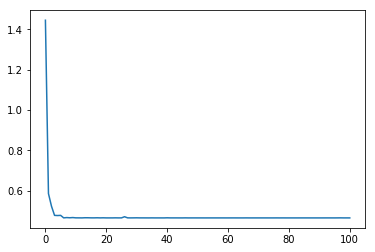

In [88]:
plt.plot(hist[:, 0])
plt.show()

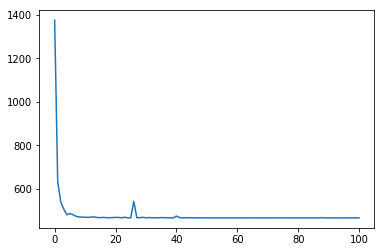

In [89]:
plt.plot(hist[:, 1])
plt.show()

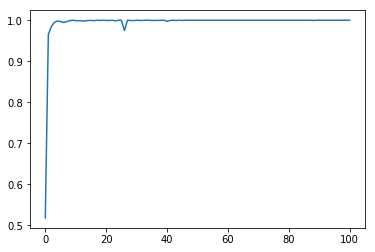

In [90]:
plt.plot(hist[:, 2])
plt.show()

In [91]:
hist = run_experiment(num_classes=3, num_samples=1, meta_batch_size=1, epochs=1e4, verbose=False)

Data generator initialized. Shape: [B, 2, 3, 784]
... Starts training ...
Time: 02:02:26.357928
Time: 02:11:17.731342
... Training ended ...


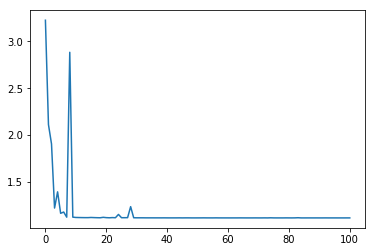

In [92]:
plt.plot(hist[:, 0])
plt.show()

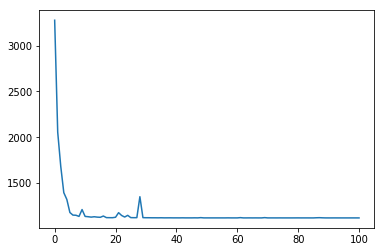

In [93]:
plt.plot(hist[:, 1])
plt.show()

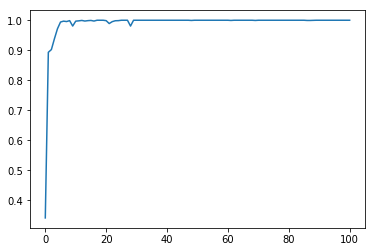

In [94]:
plt.plot(hist[:, 2])
plt.show()

In [95]:
hist = run_experiment(num_classes=4, num_samples=1, meta_batch_size=1, epochs=1e4, verbose=False)

Data generator initialized. Shape: [B, 2, 4, 784]
... Starts training ...
Time: 02:11:22.442240
Time: 02:21:43.160281
... Training ended ...


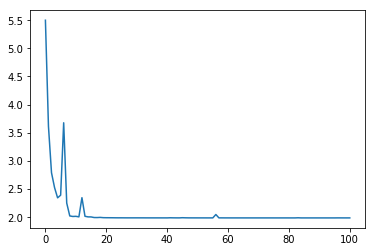

In [96]:
plt.plot(hist[:, 0])
plt.show()

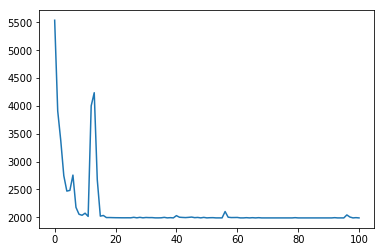

In [97]:
plt.plot(hist[:, 1])
plt.show()

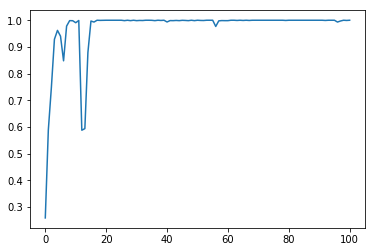

In [98]:
plt.plot(hist[:, 2])
plt.show()

In [99]:
hist = run_experiment(num_classes=4, num_samples=5, meta_batch_size=1, epochs=1e4, verbose=False)

Data generator initialized. Shape: [B, 6, 4, 784]
... Starts training ...
Time: 02:21:48.276683
Time: 02:48:56.094239
... Training ended ...


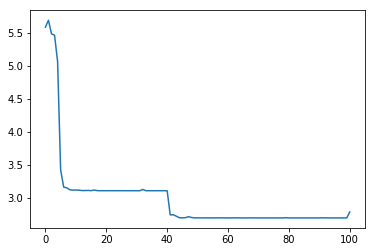

In [100]:
plt.plot(hist[:, 0])
plt.show()

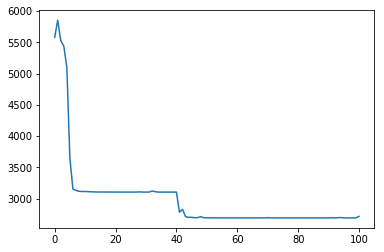

In [101]:
plt.plot(hist[:, 1])
plt.show()

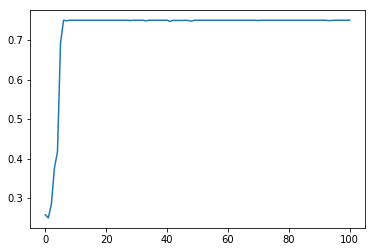

In [102]:
plt.plot(hist[:, 2])
plt.show()

In [103]:
hist = run_experiment(num_classes=10, num_samples=1, meta_batch_size=1, epochs=1e4, verbose=False)

Data generator initialized. Shape: [B, 2, 10, 784]
... Starts training ...
Time: 02:49:07.036781
Time: 03:13:50.270544
... Training ended ...


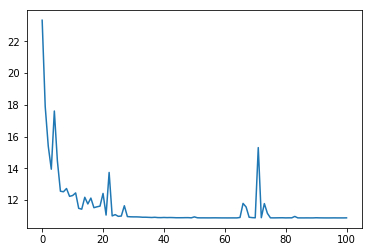

In [104]:
plt.plot(hist[:, 0])
plt.show()

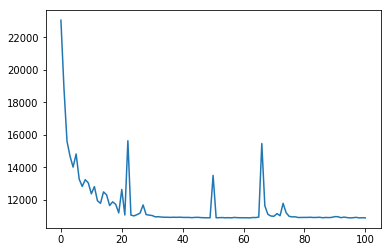

In [105]:
plt.plot(hist[:, 1])
plt.show()

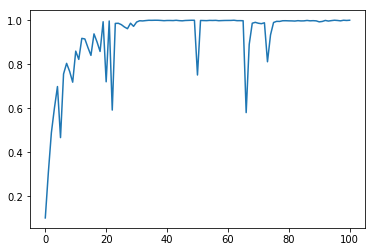

In [106]:
plt.plot(hist[:, 2])
plt.show()

In [108]:
# TODO: Check that the predictions are actually correct.
#       Accuracy is suspiciously high for small amount of training epochs.

# Problem 4: Experimentation

1. Experiment with one parameter of the model that affects the performance of the model, such as the type of recurrent layer, size of hidden state, learning rate, number of layers.
   
   Show learning curves of how the test success rate of the model changes on 1-shot, 3-way classification as you change the parameter.

   Provide a brief rationale for why you chose the parameter and what you observed in the caption for the graph.


2. Extra Credit: You can now change the MANN architecture however you want (including adding convolutions).
   
   Can you achieve over 60% test accuracy on 1-shot, 5-way classification?

# References

> [1] Brenden M. Lake, Ruslan Salakhutdinov, and Joshua B. Tenenbaum. Human-level con-
cept learning through probabilistic program induction. Science, 350(6266):1332–1338,
2015.

> [2] Adam Santoro, Sergey Bartunov, Matthew Botvinick, Daan Wierstra, and Timothy Lill-
icrap. Meta-learning with memory-augmented neural networks. In Maria Florina Balcan
and Kilian Q. Weinberger, editors, Proceedings of The 33rd International Conference
on Machine Learning, volume 48 of Proceedings of Machine Learning Research, pages
1842–1850, New York, New York, USA, 20–22 Jun 2016. PMLR.

> [3] Nikhil Mishra, Mostafa Rohaninejad, Xi Chen, and Pieter Abbeel. Meta-learning with
temporal convolutions. CoRR, abs/1707.03141, 2017.